# Visualization notebook for GP experiments and learning

In [1]:
import sys
import os
import numpy as np
from numpy.linalg import multi_dot, lstsq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import normalize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel, ExpSineSquared
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, r2_score

from scipy.linalg import expm, solve_continuous_lyapunov

import GPy

#from skgstat import Variogram

from joblib import dump, load

#Libraries for checkpoints during training
#from skopt import callbacks
#from skopt.callbacks import CheckpointSaver

from plotters import plot_gp, plot_gp_example, plot_residuals

In [2]:
def print_metrics(y_true, y_pred):
    """
    INPUT:
        y_true: the true measurements
        y_pred: the predicted measurements

    OUTPUT: 
        MSE, RMSE, R2
    """
    print('---------------------------\n')
    print('Metrics: \n')
    print('MAE: ' + str(mean_absolute_error(y_true, y_pred)))
    print('MSE: ' + str(mean_squared_error(y_true, y_pred, squared = False)))
    print('RMSE: ' + str(mean_squared_error(y_true, y_pred, squared = True)))
    print('R2: ' + str(r2_score(y_true, y_pred)) +'\n')
    print('---------------------------\n')

In [3]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 50, 1000)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    #ax.set_ylim([-3, 3])

In [4]:
checkpoint_saver = CheckpointSaver("./checkpoint.pkl", compress=9) # keyword arguments will be passed to `skopt.dump`

NameError: name 'CheckpointSaver' is not defined

# Short example visualization

In [ ]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y1 = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y1.shape)
noise = np.random.normal(0, dy)
y1 += noise

# Instantiate a Gaussian Process model
kernel = ConstantKernel(400) * ExpSineSquared(2, 3.0)# *RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T
# Fit to data using Maximum Likelihood Estimation of the parameters
#gp.fit(X, y1)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

In [ ]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10, 8))
plot_gpr_samples(gp, n_samples=5, ax=axs[0])
gp.fit(X, y1)
plot_gpr_samples(gp, n_samples=2, ax=axs[1])

In [ ]:
kern = ExpSineSquared(1.0,1.0)
Xs = np.arange(0, 10).reshape(-1,1)
ys = np.random.multivariate_normal(mean = np.zeros(Xs.shape[0]), cov = kern(Xs), size = 1)

In [ ]:
plot_gp_example(x, X, y1, y_pred, sigma)

# Simple time series

In [5]:
df = pd.read_csv('../data/mergedData.csv')
df.set_index('Timestamp', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = df.index.to_julian_date()
df["Timestamp"] = df.index
#df.index = (df.index-df.index.min())/(df.index.max()-df.index.min())

In [9]:
pos1m3DO = df.loc[:,'Pos1m3DO'].dropna().iloc[:1500]

In [10]:
# List of dates for prediction, 1 minute interval
X_train, X_test, y_train, y_test = train_test_split(pos1m3DO.index.values, pos1m3DO.values , test_size=0.3)

# Specify a range (mesh) for prediction
predictionRange = np.arange(
        '2019-07-02T16:00:00.0000000',
        '2019-07-06T00:00:00.0000000',
        np.timedelta64(1, 'm'),
        dtype='datetime64'
    )

# Format inputs
X_train = X_train.reshape(len(X_train), 1)
X_test = X_test.reshape(len(X_test), 1)
#prediction_timerange = np.append(X_train, X_test)
prediction_timerange = pos1m3DO.index.values
prediction_timerange = prediction_timerange.reshape(len(prediction_timerange), 1)

predictionRange = pd.to_datetime(predictionRange).to_julian_date().values
julian_minute = predictionRange[1] - predictionRange[0]
#predictionRange = predictionRange.reshape(len(predictionRange), 1)


In [11]:
#kernel = Matern(length_scale=1.0, nu=1.0)
#kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(1.0)

#matern=ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=[10,10], length_scale_bounds=(1e-05, 100000.0), nu=2.5)
#matern= ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=10, length_scale_bounds=(1e-05, 1e6)) + WhiteKernel(noise_level=0.5)
matern = ConstantKernel(1.0, (1e-3, 1e3)) *ExpSineSquared(length_scale = 10, periodicity= (julian_minute * 745))
#ExpSineSquared(lenght_scale = )
gpr = GaussianProcessRegressor(
    kernel=matern, 
    n_restarts_optimizer=20, 
    normalize_y=True,
    alpha=0.05
)

(3994,)


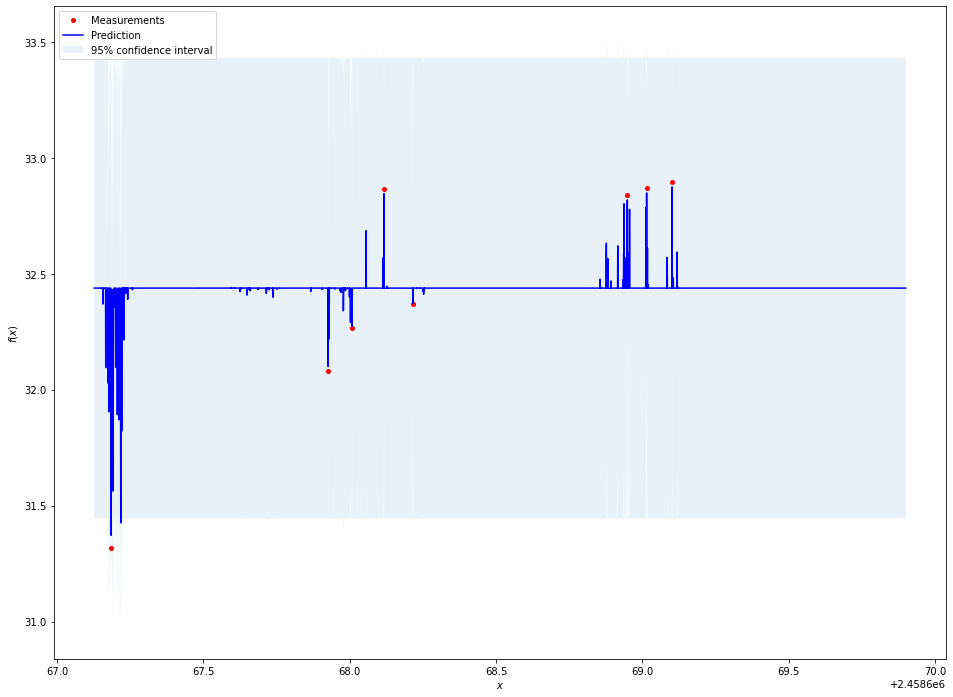

In [12]:
inputCols = ["Timestamp", "SouthOutsidem3DO", "SouthOutsidem3Temp", "Southm3DO"]
#inputCols = ["Timestamp"]
outputCols = ["SalinityInsidem6.11"]
df_all = df[inputCols + outputCols].dropna()
df_train = df_all.iloc[:8]
y = df_train[outputCols].values
Y = df_all[outputCols].values
X = df_train[inputCols]
gpr.fit(X, y)

X_pred = df[inputCols].dropna()
y_pred, y_cov = gpr.predict(X_pred, return_cov=True)
plot_gp(X_pred.Timestamp, X.Timestamp, y, y_pred[:,0], y_cov)
#fig = plt.figure(figsize=(10,8))
#plt.plot(X_pred.Timestamp,y_pred)
#df[outputCols].plot(marker='x', markersize= 10)

In [ ]:
gpr.kernel_

Optimization restart 1/10, f = 6.6917077145322175
Optimization restart 2/10, f = 7.112001190705453
Optimization restart 3/10, f = 7.905317678634049
Optimization restart 4/10, f = 7.766774393768605
Optimization restart 5/10, f = 5.333021902456046
Optimization restart 6/10, f = 7.911755937832899
Optimization restart 7/10, f = 6.165421124597201
Optimization restart 8/10, f = 7.963432204539728
Optimization restart 9/10, f = 6.382028804282113


 C:\Users\moesk\anaconda3\envs\oxygenModel\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\moesk\anaconda3\envs\oxygenModel\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 10/10, f = 5.568105774987804
(3994,)


 C:\Users\moesk\Documents\Masteroppgave\visualization\plotters.py:154: RuntimeWarning:invalid value encountered in sqrt


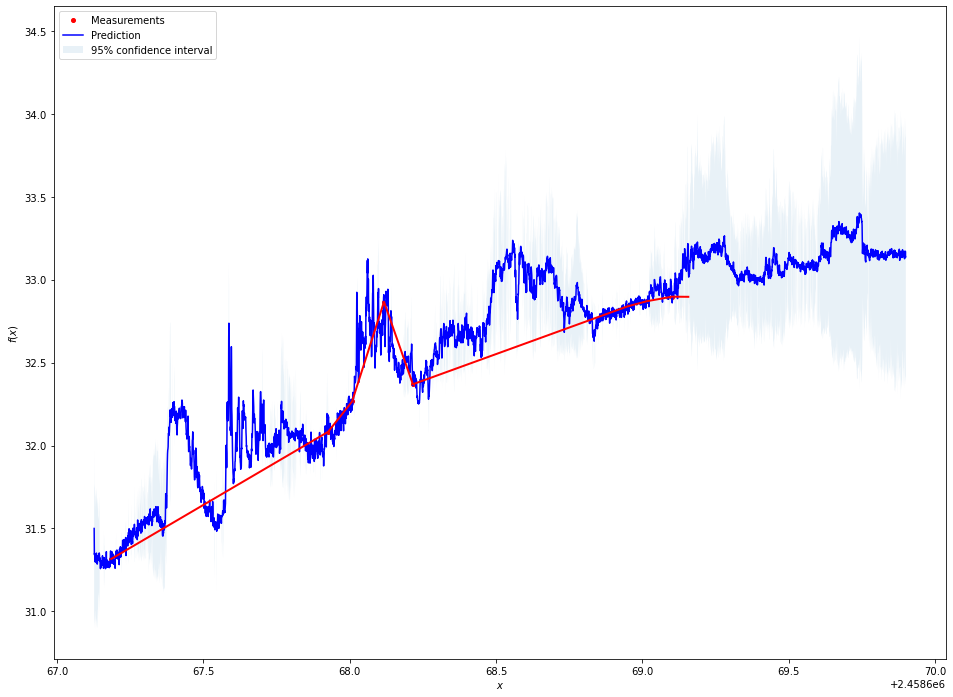

In [13]:
k = GPy.kern.Matern32(4, variance = 650, active_dims = [0,1,2,3], ARD = True) + GPy.kern.White(input_dim=4) #+ GPy.kern.White(1, active_dims=[2])
#k = GPy.kern.RBF(input_dim=1, active_dims = [0])# +GPy.kern.RBF(input_dim=1, active_dims = [0]) + GPy.kern.RBF(input_dim=1, active_dims = [1]) + GPy.kern.White(2)
#k = GPy.kern.RBF(1, active_dims = [0]) + GPy.kern.RBF(1, active_dims = [1]) + GPy.kern.RBF(1, active_dims = [2])+ GPy.kern.Exponential(1, active_dims = [3]) + GPy.kern.White(input_dim=4)
m = GPy.models.GPRegression(X.to_numpy(), y.reshape(-1,1),k, normalizer = False)
m.optimize_restarts(num_restarts = 10);
y_pred, y_cov= m.predict(X_pred.to_numpy(), full_cov=True)
plot_gp(X_pred.Timestamp, X.Timestamp, y, y_pred[:,0], y_cov)
plt.plot(df_all["Timestamp"], Y, linewidth = 2, color = 'r')

In [ ]:
m.input_sensitivity()

In [ ]:
ax = sns.pairplot(df.loc[:,outputCols + inputCols], diag_kind= 'kde', corner=True, kind = "reg")

In [ ]:
fig= plt.figure(figsize=(10,8))
plt.plot(df_all["Timestamp"], Y, linewidth = 2, color = 'r')
df["SouthOutsidem3DO"].plot(secondary_y = True,linewidth = 2, color = 'b')

In [ ]:
plt.scatter(df[outputCols], df["SouthOutsidem3DO"])

In [ ]:
y_pred, y_cov= m.predict(X_pred.to_numpy(), full_cov=True)
plot_gp(X_pred.Timestamp, X.Timestamp, y, y_pred[:,0], y_cov)
plt.plot(df_all["Timestamp"], Y, linewidth = 2, color = 'r')

In [ ]:
plot_gp(X_pred.Timestamp, X.Timestamp, y, y_pred, y_cov)

In [ ]:
#gp1_prior_samples = gp1.sample_y(X = X, n_samples=train.shape[0])
gpr.fit(X_train, y_train)
#gpr_prior_samples = gpr.sample_y(X= timeList[:600], n_samples = 1).T
#Posterior predictive mean and covariance
y_pred, y_cov = gpr.predict(prediction_timerange, return_cov=True)

In [ ]:
#y_pred, y_cov = gpr.predict(prediction_timerange, return_cov=True)
y_pred, y_cov = gpr.predict(X_test, return_cov=True)

In [ ]:
#plt.plot(X_train, y_train, linestyle='none', marker='o', markersize=3, color='r')
#plt.plot(X_test, y_test)
gpr.kernel_

In [ ]:
#gpr.score(X_test,y_test)
print_metrics(y_test, y_pred)

In [ ]:
plot_gp(prediction_timerange, X_test, y_test, y_pred, y_cov)
#plot_gp(X_test, X_test, y_test, y_pred, y_cov)

In [ ]:
plot_residuals(X_test, (y_test-y_pred))

In [ ]:
plt.scatter(X_test, y_test, s=7, marker ='o', color='r', label='Residual')

In [ ]:
plot_residuals(y_pred, (y_test-y_pred))

# Spatial Gaussian Process

In [ ]:
#sdf = df.loc[:,['Pos1m3DO','Pos1m6DO','Pos1m9DO','Pos1m12DO']]
sdf = df[[col for col in df.columns if 'm3' in col and 'DO' in col]].dropna(axis = 0, how = 'all')
sdf.head()

In [ ]:
depth = np.linspace(3, 12, sdf.shape[1])
sdf.iloc[0].values

In [ ]:
# List of dates for prediction, 1 minute interval
X = depth
#X_train = train.index.values
y = sdf.iloc[0].values
#y_train = train.values

# Specify a range (mesh) for prediction
predictionRange = np.arange(
        '2019-07-02T16:00:00.0000000',
        '2019-07-06T00:00:00.0000000',
        np.timedelta64(30, 's'),
        dtype='datetime64'
    )

# Format inputs
X = X.reshape(len(X), 1)
#predictionRange = pd.to_datetime(predictionRange).to_julian_date().values

predictionRange = np.linspace(2,13,100)
predictionRange = predictionRange.reshape(len(predictionRange), 1)


#X = [pd.to_numeric(time, downcast='float') for time in X]
#predictionRange = [pd.to_numeric(time, downcast='float') for time in predictionRange]

X_and_predictionRange = [*X, *predictionRange]

In [ ]:
#kernel = Matern(length_scale=1.0, nu=1.0)
#kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(1.0)
length_scale_param=0.0015
length_scale_bounds_param=(1e-05, 100000.0)
nu_param=2.5

matern=Matern(length_scale=length_scale_param, length_scale_bounds=length_scale_bounds_param, nu=nu_param)
kernel = ConstantKernel(0.5) * RBF()

sgpr = GaussianProcessRegressor(
    kernel=kernel, 
    n_restarts_optimizer=9, 
    normalize_y=True,
    alpha = 0.05
)

In [ ]:
#gp1_prior_samples = gp1.sample_y(X = X, n_samples=train.shape[0])
sgpr.fit(X, y)
#gpr_prior_samples = gpr.sample_y(X= timeList[:600], n_samples = 1).T
#Posterior predictive mean and covariance
y_pred, y_cov = sgpr.predict(predictionRange, return_cov=True)
sgpr.kernel_

In [ ]:
sgpr.kernel_

In [ ]:
plot_gp(predictionRange, X, y, y_pred, y_cov)

# Spatio-Temporal Gaussian Process

## Depth and time 

In [ ]:
stdf = df.loc[:,['Pos1m3DO','Pos1m6DO','Pos1m9DO','Pos1m12DO']].dropna(axis = 0, how = 'all')
stdf = stdf.iloc[:100]
y_train, y_test = train_test_split(stdf, test_size=0.2)

In [ ]:
#kernel = Matern(length_scale=1.0, nu=1.0)
#kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(1.0)
length_scale_param=0.0015
length_scale_bounds_param=(1e-05, 100000.0)
nu_param=2.5

matern=Matern(length_scale=length_scale_param, length_scale_bounds=length_scale_bounds_param, nu=nu_param)
kernel = RBF(length_scale=[2.0, 0.015]) + ExpSineSquared() + WhiteKernel()

stgpr = GaussianProcessRegressor(
    kernel=kernel, 
    n_restarts_optimizer=20, 
    normalize_y=True,
    #alpha = 0.05,
    #n_jobs = -1
)

In [ ]:
X= []
for col in stdf.columns:
    depth = int(re.search('m\d+', col).group()[1:])
    X.extend([(depth, timestamp) for  timestamp in stdf[col].dropna().index])

X = np.array(X)
y = stdf.values.ravel('F')[~np.isnan(stdf.values.ravel('F'))]

# Specify a range (mesh) for prediction
prediction_timerange = np.arange(
        '2019-07-02T16:00:00.0000000',
        '2019-07-06T00:00:00.0000000',
        np.timedelta64(30, 's'),
        dtype='datetime64'
    )
prediction_timerange = pd.to_datetime(prediction_timerange).to_julian_date().values
#prediction_timerange = prediction_timerange.reshape(len(prediction_timerange), 1)

prediction_spacerange = np.linspace(2,13,55)
prediction_mesh = [(3.0, timestamp) for timestamp in prediction_timerange]
prediction_mesh = np.array(prediction_mesh)
# Format inputs
#X.reshape(-1, 1)
#np.set_printoptions(precision=16)


In [ ]:
prediction_mesh = [(depth, X[50][1]) for depth in prediction_spacerange]
prediction_mesh = np.array(prediction_mesh)

In [ ]:
stgpr.fit(X, y)
#joblib.dump(stgpr, 'stgpr1_1')

In [ ]:
y.mean(axis=0)

In [ ]:
y_pred, y_cov = stgpr.predict(prediction_mesh, return_cov=True)

In [ ]:
stgpr.score(X,y)

In [ ]:
stgpr.kernel_

In [ ]:
plot_gp(prediction_spacerange, [depth[0] for depth in X], y, y_pred, y_cov)
plt.plot(np.linspace(3, 12, 4), stdf.iloc[50].values, marker='x', linestyle='none', markersize =20.0)
#save fig

## Long, lat and Time

In [ ]:
DOm3columns = [col for col in df.columns if 'm3' in col and 'DO' in col]

stdf = df.loc[:,DOm3columns].dropna(axis = 0, how = 'all')
stdf = stdf.iloc[:100]

y_train, y_test = train_test_split(stdf, test_size=0.2)

In [ ]:
X= []
for col in stdf.columns:
    depth = int(re.search('m\d+', col).group()[1:])
    X.extend([(depth, timestamp) for  timestamp in stdf[col].dropna().index])

X = np.array(X)
y = stdf.values.ravel('F')[~np.isnan(stdf.values.ravel('F'))]

# Specify a range (mesh) for prediction
prediction_timerange = np.arange(
        '2019-07-02T16:00:00.0000000',
        '2019-07-06T00:00:00.0000000',
        np.timedelta64(30, 's'),
        dtype='datetime64'
    )
prediction_timerange = pd.to_datetime(prediction_timerange).to_julian_date().values
#prediction_timerange = prediction_timerange.reshape(len(prediction_timerange), 1)

prediction_spacerange = np.linspace(2,13,55)

prediction_mesh = [(3.0, timestamp) for timestamp in prediction_timerange]
prediction_mesh = np.array(prediction_mesh)
# Format inputs
#X.reshape(-1, 1)
#np.set_printoptions(precision=16)

In [ ]:
def a(type):
    if type =='a':
        def kernel(x1, x2):
            print(x1)
            print(x2)
    else:
        def kernel(x1, x2):
            print('No kernel')
    return kernel

def b(x1, x2, func):
    c = func(x1,x2)
    return c

In [ ]:
class Params(object):
    def __init__(self):
        self.data = {}
        self.data['numLocs'] = 100
        
class gptest(object):
    def __init__(self):
        self.params = Params()
        print(self.params.data)

In [ ]:
class Params(object):
    def __init__(self):
        self.data = {}
        self.data['numLocs'] = 100

        self.data['spaceLocsIdx'] = np.arange(0,self.data['numLocs']).conj().T
        self.data['spaceLocs'] = np.arange(0, self.data['numLocs']).conj().T
        
        self.data['samplingTime'] = 0.5
        self.data['startTime'] = 0
        self.data['endTime'] = 10
                
        self.data['noiseStd'] = 0.316

        self.data['kernel'] = {}

        self.data['kernel']['space'] = {}
        self.data['kernel']['space']['type'] = 'exponential'
        self.data['kernel']['space']['scale'] = 1
        self.data['kernel']['space']['std'] = 1

        self.data['kernel']['time'] = {}
        self.data['kernel']['time']['type'] = 'exponential' #'exponential', 'gaussian', 'periodic'
        self.data['kernel']['time']['scale'] = 1            # NOTE: to use gaussian kernel with GPKF
        self.data['kernel']['time']['std'] = 1              # scale and std must be set to 1
        self.data['kernel']['time']['frequency'] = 1
        
        # NONPERAMETRIC KERNEL parameter
        #self.np.kernel = self.data.kernel
        
        # GPKF parameters
        self.gpkf = {}
        self.gpkf['kernel'] = self.data['kernel']

        # Compute additional (common) parameters
        self.data['spaceLocsMeasIdx'] = np.sort(np.random.choice(self.data['spaceLocsIdx'], int(np.around(0.8*self.data['numLocs'])), replace=False))
        #print(self.data['spaceLocs'][self.data['spaceLocsMeasIdx']])

        self.data['spaceLocsMeas'] = self.data['spaceLocs'][self.data['spaceLocsMeasIdx']]
        self.data['spaceLocsPredIdx'] = np.setdiff1d(self.data['spaceLocsIdx'], self.data['spaceLocsMeasIdx'])
        self.data['spaceLocsPred'] = self.data['spaceLocs'][self.data['spaceLocsPredIdx']]

        """ REMEMBER THAT THAT THIS IS DIFFERENT! ORIGINAL:
        Params.data.spaceLocsMeasIdx = sort(datasample(Params.data.spaceLocsIdx, round(0.8*Params.data.numLocs), 'Replace', false));
        Params.data.spaceLocsMeas = Params.data.spaceLocs(Params.data.spaceLocsMeasIdx,:);
        Params.data.spaceLocsPredIdx = setdiff(Params.data.spaceLocsIdx, Params.data.spaceLocsMeasIdx);
        Params.data.spaceLocsPred = Params.data.spaceLocs(Params.data.spaceLocsPredIdx,:);
        """

        self.data['timeInstants'] = np.arange(self.data['startTime'], self.data['endTime'] + self.data['samplingTime'], self.data['samplingTime']).conj().T

        if self.gpkf['kernel']['time']['type'] == 'exponential':
            self.gpkf['kernel']['time']['num'] = np.array([np.sqrt(2*self.gpkf['kernel']['time']['scale'] / self.gpkf['kernel']['time']['std'])])
            self.gpkf['kernel']['time']['den'] = np.array([1/self.gpkf['kernel']['time']['std']])
            
        elif self.gpkf['kernel']['time']['type'] == 'periodic':
            self.gpkf['kernel']['time']['num'] = np.array([np.sqrt(2*self.gpkf['kernel']['time']['scale'] / self.gpkf['kernel']['time']['std']) * np.array([np.sqrt((1/self.gpkf['kernel']['time']['std'])**2 + (2*pi*self.gpkf['kernel']['time']['frequency'])**2) , 1])])
                    
            self.gpkf['kernel']['time']['den'] = np.array([((1/self.gpkf['kernel']['time']['std'])**2 + (2*pi*self.gpkf['kernel']['time']['frequency'])**2 ), 2/self.gpkf['kernel']['time']['std']])

        else:
            print('Not admissible kernel type')

In [ ]:
def createDiscreteTimeSys(num_coeff, den_coeff, Ts):
    # state dimension
    stateDim  = np.max(den_coeff.shape)

    if stateDim ==1:
        print('1 dim')
        F = -den_coeff       # state matrix
        A = np.exp(F * Ts)   # Discretization
        G = np.array([1])
    else:
        print('more dims')
        F = np.diag(np.ones((1,stateDim-1)),1).copy()
        F[stateDim-1] = -den_coeff
        A = expm(F * Ts)  # state matrix
        G = np.vstack([np.zeros((stateDim-1,1)),1]) # input matrix
    
    # output matrix
    C = np.zeros((1,stateDim))
    C[0:np.max(num_coeff.shape)] = num_coeff

    # state variance as solution of the lyapunov equation
    V = solve_continuous_lyapunov(F, -np.matmul(G, G.conj().T))

    # discretization of the noise matrix
    Q = np.zeros(stateDim)
    Ns = 10000        
    t = Ts/Ns
    if stateDim == 1:
        for n in np.arange(t, Ts+t, step=t):
            Q = Q + t * np.exp(np.dot(F,n)) * np.dot(G,G.conj().T) * np.exp(np.dot(F,n)).conj().T
    else:
        for n in np.arange(t, Ts+t, step=t):
            Q = Q + np.linalg.multi_dot([t, expm(np.dot(F,n)), np.dot(G,G.conj().T), expm(np.dot(F,n)).conj().T])
    
    return A, C, V, Q

In [ ]:
def kernelFunction(type, params):
    """
    kernel = kernelFunction(type,kernel_specific_parameter) returns a function
    describing the desired kernel.

    INPUT: type: kernel type
           args: necessary (kernel specific) paremeters. 
                 Consistency must be ensured by the user

    OUTPUT: kernel: kernel function
    """
    if type == 'separable':
        ks = kernelFunction(params['space']['type'], params['space']['scale'], params['space']['std'])
        kt = kernelFunction(params['time']['type'], params['time']['scale'], params['time']['std'])
        def kernel(x1,x2):
            return np.matmul(kt(x1[0],x2[0]), ks(x1[1:end],x2[1:end]))
    
    elif type == 'exponential':
        scale = params['scale']
        std_dev = params['std']
        def kernel(x1,x2):
            return scale *np.exp(-np.linalg.norm(x1-x2) / std_dev)

    elif type == 'gaussian':
        scale = params['scale']
        std_dev = params['std']
        def kernel(x1,x2):
            return np.dot(scale, (np.exp(-np.linalg.norm(x1-x2)**2 / (2*std_dev**2))))
        
    elif type == 'periodic':
        scale = params['scale']
        std_dev = params['std']
        frequency = params['frequency']
        def kernel(x1,x2):
            return np.linalg.multi_dot([scale, np.cos(2*pi*frequency * np.linalg.norm(x1-x2)), np.exp(-np.linalg.norm(x1-x2)/std_dev)])
        
    else:
        print('Unknown type of kernel')

    return kernel

In [ ]:
def kernelSampled(input_set_1, input_set_2, kernel_func):
    """
    kernelSampled returns sampled kernel
       K = kernelSampled(kernel_function, *args) returns the kernel 
       (given as input function) sampled across the desired input set
       Consistency among kernel function and input sets must be priorly ensure
       by the user
    """

    # cardinalities of input sets
    n_input1 = input_set_1.shape[0]
    n_input2 = input_set_2.shape[0]

    # initialize
    K = np.zeros((n_input1,n_input2))

    for i in np.arange(0, n_input1):
        for j in np.arange(0, n_input2):
            #todo: fix [i,:]
            K[i,j] = kernel_func(input_set_1[i] , input_set_2[j])

    return K

In [ ]:
def kernelSpaceTimeSampled(space_locs1, space_locs2, time_instants1, time_instants2, param):
    """
    K = kernelSpaceTimeSampled(space_locs, time_instants, kernel_param) build the 
    space and time kernels, sample them in the desired set of input 
    locations and returns the kernel (given as input function) sampled 
    across the desired input set.
    Consistency among kernel function and input sets must be priorly ensure
    by the user

    This way of sampling the space-time kernel is just one possibility. It
    would be possible to directly use the function kernelSampled by properly
    specifying the input sets. However, this implementation is more efficient
    """

    # compute kernel functions
    kernel_space = kernelFunction(param['space']['type'], param['space'])
    kernel_time = kernelFunction(param['time']['type'] , param['time'])

    # sampled kernels
    Ks = kernelSampled(space_locs1, space_locs2, kernel_space)
    Kt = kernelSampled(time_instants1, time_instants2, kernel_time)

    # overall space-time kernel
    K = np.kron(Kt,Ks)

    return K

In [ ]:
def estimation(meas, noiseVar, params):

        # number of measured locations and time instants
        numSpaceLocs,numTimeInstants = meas.shape

        # create DT state space model
        a,c,v0,q = createDiscreteTimeSys(params.gpkf['kernel']['time']['num'], params.gpkf['kernel']['time']['den'], params.data['samplingTime'])
        
        # create space kernel
        kernel_space = kernelFunction(params.gpkf['kernel']['space']['type'], params.gpkf['kernel']['space'])
        Ks_chol = np.linalg.cholesky(kernelSampled(params.data['spaceLocsMeas'], params.data['spaceLocsMeas'], kernel_space)).conj()
        
        # initialize quantities needed for kalman estimation
        I = np.eye(numSpaceLocs)
        A = np.kron(I,a)
        C = np.matmul(Ks_chol, np.kron(I,c))
        V0 = np.kron(I,v0)
        Q = np.kron(I,q)
        R = np.zeros((numSpaceLocs, numSpaceLocs, numTimeInstants))
        for t in np.arange(0, numTimeInstants):
            R[:,:,t] = np.diag(noiseVar[:,t]).copy()
        
        # compute kalman estimate
        x,V,xp,Vp,logMarginal = kalmanEst(A,C,Q,V0,meas,R)

        # output function
        posteriorMean = np.matmul(C,x)
        posteriorMeanPred = np.matmul(C,xp)

        # posterior variance
        O3 = np.zeros((numSpaceLocs, numSpaceLocs, numTimeInstants))
        posteriorCov = O3.copy()
        posteriorCovPred = O3.copy()
        outputCov = O3.copy()
        outputCovPred = O3.copy()

        for t in np.arange(0, numTimeInstants):
            
            # extract variance
            posteriorCov[:,:,t] = np.linalg.multi_dot([C, V[:,:,t], C.conj().T])
            posteriorCovPred[:,:,t] = np.linalg.multi_dot([C, Vp[:,:,t], C.conj().T])
            
            # compute output variance
            outputCov[:,:,t] = posteriorCov[:,:,t] + R[:,:,t]
            outputCovPred[:,:,t] = posteriorCovPred[:,:,t] + R[:,:,t]
        
        return posteriorMean, posteriorCov, logMarginal

In [ ]:
def kalmanEst(A, C, Q, V0, meas, noiseVar):

    numTimeInstants = meas.shape[1]
    stateDim = A.shape[0]
    I = np.eye(stateDim)
    times = np.zeros((numTimeInstants,1))
    logMarginal = 0

    # initialization
    xt = np.zeros((stateDim,1))
    Vt = V0
    xp = np.zeros((stateDim,numTimeInstants))
    Vp = np.zeros((stateDim,stateDim,numTimeInstants))
    x = np.zeros((stateDim,numTimeInstants))
    V = np.zeros((stateDim,stateDim,numTimeInstants))
    
    #print(noiseVar)
    for t in np.arange(0, numTimeInstants):
        # prediction
        xpt = np.matmul(A,xt)
        Vpt = A @ Vt @ A.conj().T + Q

        # correction
        notNanPos = np.logical_not(np.isnan(meas[:,t]))
        Ct = C[notNanPos,:]
        Rt = noiseVar[:,:,t][np.ix_(notNanPos, notNanPos)]

        innovation = meas[:,t][np.newaxis].T[np.ix_(notNanPos)] -  (Ct @ xpt)
        innovVar = np.linalg.multi_dot([Ct, Vpt, Ct.conj().T]) + Rt
        K = np.linalg.solve(innovVar.conj().T,(np.matmul(Vpt, Ct.conj().T)).conj().T).conj().T   # kalman gain
        correction = np.matmul(K, innovation)
        
        xt = xpt + correction

        Vt = np.linalg.multi_dot([(I - np.matmul(K,Ct)), Vpt ,(I - np.matmul(K,Ct)).conj().T]) + np.linalg.multi_dot([K, Rt, K.conj().T])

        # save values
        xp[:,t] = xpt[:,0]
        Vp[:,:,t] = Vpt[:,:]
        x[:,t] = xt[:,0]
        V[:,:,t] = Vt[:,:]
          
        # computations for the marginal likelihood
        l1 = np.sum(np.log(np.linalg.eig(innovVar)[0]))
        l2 = np.matmul(innovation.conj().T, np.linalg.solve(innovVar, innovation))

        logMarginal = logMarginal +  0.5*(np.max(innovation.shape) * np.log(2*np.pi) + l1 + l2)
        
    return x, V, xp, Vp, logMarginal

In [ ]:
def prediction(meas, noiseVar, params):

        postMean, postCov, logMarginal = estimation(meas, noiseVar, params)
        
        kernel_space = kernelFunction(params.gpkf['kernel']['space']['type'], params.gpkf['kernel']['space'])
        kernelSection = kernelSampled(params.data['spaceLocsPred'], params.data['spaceLocsMeas'], kernel_space)
        kernelPrediction = kernelSampled(params.data['spaceLocsPred'], params.data['spaceLocsPred'], kernel_space)
        Ks = kernelSampled(params.data['spaceLocsMeas'], params.data['spaceLocsMeas'], kernel_space)

        #I = np.eye(Ks.shape[0])
        Ks_inv = np.linalg.inv(Ks)

        numSpaceLocsPred = np.max(params.data['spaceLocsPred'].shape)
        numTimeInsts = np.max(params.data['timeInstants'].shape)
        predictedCov = np.zeros((numSpaceLocsPred, numSpaceLocsPred, numTimeInsts))
        scale = params.gpkf['kernel']['time']['scale']

        predictedMean = np.matmul(kernelSection, np.matmul(Ks_inv, postMean))
                
        for t in np.arange(0, numTimeInsts):
            W = Ks_inv @ (Ks - postCov[:,:,t].conj().T / scale) @ Ks_inv
            predictedCov[:,:,t] = np.linalg.multi_dot([scale, (kernelPrediction - np.linalg.multi_dot([kernelSection, W, kernelSection.conj().T]))])

        return predictedMean, predictedCov

In [ ]:
def generateSyntheticData(param):
    # create space-time sampled kernel
    K = kernelSpaceTimeSampled(param['spaceLocs'], param['spaceLocs'], param['timeInstants'], param['timeInstants'], param['kernel'])

    # sample "true" (zero mean) GP and measurements
    f = np.random.multivariate_normal(np.zeros(K.shape[0]), K, 1).conj().T

    # rearganization in matrix form (row:space, columns:time)
    numSpaceLocs = np.max(param['spaceLocs'].shape)
    numTimeInst = np.max(param['timeInstants'].shape)
    F = np.reshape(f , (numSpaceLocs , numTimeInst))

    # create measurements
    numSpaceLocsMeas = np.max(param['spaceLocsMeas'].shape)
    Y = F[param['spaceLocsMeas'],:] + param['noiseStd'] * np.random.standard_normal((numSpaceLocsMeas, numTimeInst))

    # delete (randomly) some measurements and build measurement cov matrix
    noiseVar = param['noiseStd']**2 * np.ones((numSpaceLocsMeas, numTimeInst))
    for t in np.arange(0,numTimeInst):
        idx = np.sort(np.random.permutation(numSpaceLocsMeas)[:np.random.randint(numSpaceLocsMeas)]).conj().T
        Y[idx,t] = np.nan
        noiseVar[idx,t] = np.inf

    return F, Y, noiseVar

In [ ]:
params = Params()
#meas = np.array([[1, 2],[3,4],[5,6]])
#noiseVar = 0.1 * np.ones((3,2))
F, meas, noiseVar = generateSyntheticData(params.data)
pMean, pCov, logMarginal = estimation(meas, noiseVar, params)
predMean, predCov = prediction(meas, noiseVar, params)

In [ ]:
print(predMean.shape)